In [ ]:
import numpy as np
import pylab as plt
import pandas as pd
import scipy.stats as sc
from scipy.interpolate import interp1d

In [ ]:
# =============================================================================
# FUNCIÓN GAUSSIANA
# =============================================================================

def gaussian(x,mu,sigma,peak):
    return peak - 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2/2*sigma**2)

# =============================================================================
# INPUTS
# =============================================================================

mu    = 6708 # Mean of spectral feature
sigma = 1 # Desviación estándar 
peak  = 1 # Pico de la distribución
Lmin  = 6695 # Mínima longitud de onda a generar
Lmax  = 6721 # Máxima longitud de onda a generar
Lstep = 0.1 # Paso en longitudes de onda
SNR = [5, 10, 20, 30, 40, 50, 100] # Señales a Ruido
N = 5 # Número de simulaciones

# Valores definidos para distinguir entre la línea y el continuo
L1min = 6695
L1max = 6705
L2min = 6711
L2max = 6721

# =============================================================================
# CREAMOS LAS LONGITUDES DE ONDA Y LA LÍNEA ESPECTRAL
# =============================================================================

ask = input("Would you rather work with a real spectra or create a sintetic one? r/s:") 

if ask == 'r':
    spectra = pd.read_csv('../data/spectra/gagne1345_R.fits.csv')
    full_x_val = spectra['WAVELENGTH']
    full_f_val = spectra['FLUX']    
    
    # Graficamos el espectro real
    plt.figure(figsize=(6,6))
    plt.plot(full_x_val, full_f_val, '-b', linewidth=1)
    plt.title("Espectro Real")
    plt.xlabel("Longitud de Onda (A)")
    plt.ylabel("Flujo")
    plt.show()
   
    # Restringimos el muestreo de puntos en torno a la línea del litio    
    new_spectra = spectra[(full_x_val > Lmin) & (full_x_val < Lmax)]
    
    x_val = new_spectra['WAVELENGTH']
    f_val = new_spectra['FLUX']
    
    # Distingimos entre la linea y el continuo
    lithium_line = new_spectra[(x_val > 6707) & (x_val < 6709)]
    cont_region = new_spectra[((x_val < 6707) & (x_val > Lmin)) | (x_val > 6709) & (x_val < Lmax)]

    #Ajuste lineal del continuo
    coef = np.polyfit(cont_region.WAVELENGTH, cont_region.FLUX, 4)
    poly1d_fn = np.poly1d(coef)
    
    #Cálculo de flujos
    F_cont = poly1d_fn(new_spectra.WAVELENGTH)

    #Agregamos el ajuste de flujos al data frame
    new_spectra["fluxfitted"] = F_cont
    
    # Graficamos la selección de puntos y el ajuste
    plt.plot(cont_region.WAVELENGTH, cont_region.FLUX, linewidth=0.75, label="Continuo", color='g')
    plt.plot(lithium_line.WAVELENGTH, lithium_line.FLUX, linewidth=0.75, label="Línea espectral", color='b')
    plt.plot(new_spectra.WAVELENGTH, new_spectra.fluxfitted, '-k', label="Ajuste")
    plt.xlabel("Longitud de Onda (A)")
    plt.ylabel("Flujo")
    plt.legend(loc='best')
    plt.show()
    
    # Calculamos el ancho equivalente sin ruido
    R = new_spectra.FLUX/new_spectra.fluxfitted
    EW_real = 0

    for r in R:
        EW_real += 1 - r
    
    print("Ancho equivalente real sin ruido para la línea de absorción del Li:", EW_real)
        
    
elif ask == 's':
    x_val = np.arange(Lmin,Lmax,Lstep)
    f_val = gaussian(x_val,mu,sigma,peak)
    
    
# =============================================================================
# RUIDO
# =============================================================================

#Inicializamos un vector que tendrá los anchos equivalentes promedio por simulación
W_mean_vec = []
sigma_W_vec = []

#Iteramos en SNR
for m in SNR:

    #Definimos la desviación estándar del ruido
    sigma_noise = f_val/m

    # Inicializamos un vector que tendrá los anchos equivalentes por simulación
    all_W = [] 

    #Simulamos N veces los cálculos
    for n in range(N):

        #Construimos el ruido y la nueva señal 
        noise = np.random.normal(0, sigma_noise)
        new_signal = f_val + noise

        #Graficamos el ruido
        """
        plt.figure()
        plt.xlim([Lmin,Lmax])

        plt.plot(x_val, f_val, color='r', label="Señal teórica")
        plt.plot(x_val, new_signal, linewidth=1, color='k', label="SNR: " + str(m))
        plt.xlabel("Longitud de onda (A)")
        plt.ylabel("Flujo")
        plt.title("Ruido Aleatorio para un SNR de: " + str(m))
        plt.legend(loc='upper right', bbox_to_anchor=(1,1))
        """

        # =============================================================================
        # CÁLCULOS DE FLUJOS
        # =============================================================================

        # Creamos un data frame con los datos a utilizar
        d = {'wavelength': x_val, 'signal': f_val, 'newsignal': new_signal}
        data = pd.DataFrame(data=d)

        # Filtramos de acuerdo a los límites definidos en longitud de onda
        # a la izquierda, derecha y en la linea
        data_line = data[(data.wavelength > 6707) & (data.wavelength < 6709)]
        data_cont = data[(data.wavelength < 6707) | (data.wavelength > 6709)]


        #Ajuste lineal del continuo
        coef = np.polyfit(data_cont.wavelength, data_cont.newsignal, 2)
        poly1d_fn = np.poly1d(coef)

        #Cálculo de flujos
        F_cont = poly1d_fn(data.wavelength)

        #Agregamos el ajuste de flujos al data frame
        data["fluxfitted"] = F_cont

        #Mostramos la selección de puntos y el ajuste
        """
        plt.figure()
        plt.xlim([Lmin,Lmax])

        #plt.plot(x_val,f_val, color='r', label="Señal teórica")
        plt.plot(data_cont.wavelength, data_cont.newsignal, linewidth=0.75, label="Continuo", color='g')
        plt.plot(data_line.wavelength, data_line.newsignal, linewidth=0.75, label="Línea espectral", color='b')
        plt.plot(data.wavelength, data.fluxfitted, '-k', label="Ajuste")
        plt.xlabel("Longitud de onda (A)")
        plt.ylabel("Flujo")
        if ask == 'r':
            plt.title("Ruido aleatorio + Espectro Real con SNR: " + str(m))
        else:
            plt.title("Ruido aleatorio + Gaussiana teórica con SNR: " + str(m))
        plt.gca().set_ylim(0,2)
        plt.legend(loc='upper right', bbox_to_anchor=(1,1))
        plt.savefig(f"./graphics/noise_snr_{m}.jpg")
        """

        # =============================================================================
        # ANCHO EQUIVALENTE 
        # =============================================================================

        # Inicializamos el ancho equivalente W y una cantidad auxiliar para su cálculo

        R = data.newsignal/data.fluxfitted
        W = 0

        for r in R:
            W += 1 - r 

        print('Ancho equivalente W: ', W, 'para un SNR de: ', m)

        #Agregamos todos los W al vector all_W
        all_W.append(W)

        # Vamos a definir el promedio de los W generados por simulacion
        mean_W = 0
        mean_W = np.mean(all_W) # Media de los W
        sigma_W = np.std(all_W) # Desvio estandar de los W

        # Inicializamos el gráfico de W vs SNR
        for i in all_W:
            plt.scatter(m, i, color='none', edgecolor='g')

    plt.plot(m, mean_W, 'bo', markersize = 5)

    print("Promedio de W: ", mean_W)

    print("Desvio estandar de los W: ", sigma_W,'\n')

    # Agregamos los desvios estándar al vector global de std

    sigma_W_vec.append(sigma_W)
    print("Error de promedios: ", sigma_W_vec,'\n')

    #Agregamos el promedio al vector global de promedios

    W_mean_vec.append(mean_W)
    print("Vector de promedios: ", W_mean_vec,'\n')

#Graficamos el ancho equivalente en función del SNR
plt.errorbar(SNR, W_mean_vec, yerr=sigma_W_vec, elinewidth=2,
             ecolor='r', color="k")  
plt.xlabel("SNR")    
plt.ylabel("EW (A)")
plt.title("Ancho equivalente vs Razón Señal-Ruido")
plt.savefig("./graphics/EW_vs_SNR.jpg")
plt.show()

In [ ]:
# =============================================================================
    # RUIDO
    # =============================================================================

    #Inicializamos un vector que tendrá los anchos equivalentes promedio por simulación
    W_mean_vec = []
    sigma_W_vec = []

    #Iteramos en SNR
    for m in SNR:

        #Definimos la desviación estándar del ruido
        sigma_noise = f_val/m

        # Inicializamos un vector que tendrá los anchos equivalentes por simulación
        all_W = [] 

        #Simulamos N veces los cálculos
        for n in range(N):

            #Construimos el ruido y la nueva señal 
            noise = np.random.normal(0, sigma_noise)
            new_signal = f_val + noise
            
            #Graficamos el ruido
            """
            plt.figure()
            plt.xlim([Lmin,Lmax])

            plt.plot(x_val, f_val, color='r', label="Señal teórica")
            plt.plot(x_val, new_signal, linewidth=1, color='k', label="SNR: " + str(m))
            plt.xlabel("Longitud de onda (A)")
            plt.ylabel("Flujo")
            plt.title("Ruido Aleatorio para un SNR de: " + str(m))
            plt.legend(loc='upper right', bbox_to_anchor=(1,1))
            """
            
            # =============================================================================
            # CÁLCULOS DE FLUJOS
            # =============================================================================

            # Creamos un data frame con los datos a utilizar
            d = {'wavelength': x_val, 'signal': f_val, 'newsignal': new_signal}
            data = pd.DataFrame(data=d)

            # Filtramos de acuerdo a los límites definidos en longitud de onda
            # a la izquierda, derecha y en la linea
            data_line = data[(data.wavelength > 6707) & (data.wavelength < 6709)]
            data_cont = data[(data.wavelength < 6707) | (data.wavelength > 6709)]

            #Ajuste lineal del continuo
            coef = np.polyfit(data_cont.wavelength, data_cont.newsignal, 2)
            poly1d_fn = np.poly1d(coef)

            #Cálculo de flujos
            F_cont = poly1d_fn(data.wavelength)

            #Agregamos el ajuste de flujos al data frame
            data["fluxfitted"] = F_cont

            #Mostramos la selección de puntos y el ajuste
            
            plt.figure()
            plt.xlim([Lmin,Lmax])

            #plt.plot(x_val,f_val, color='r', label="Señal teórica")
            plt.plot(data_cont.wavelength, data_cont.newsignal, linewidth=0.75, label="Continuo", color='g')
            plt.plot(data_line.wavelength, data_line.newsignal, linewidth=0.75, label="Línea espectral", color='b')
            plt.plot(data.wavelength, new_spectra.fluxfitted, '-k', label="Ajuste")
            plt.xlabel("Longitud de onda (A)")
            plt.ylabel("Flujo")
            plt.gca().set_ylim(0,2)
            plt.title("Ruido aleatorio + Espectro Real con SNR: " + str(m))
            plt.legend(loc='upper right', bbox_to_anchor=(1,1))
            
            
            # =============================================================================
            # ANCHO EQUIVALENTE 
            # =============================================================================

            # Inicializamos el ancho equivalente W y una cantidad auxiliar para su cálculo

            R = data.newsignal/data.fluxfitted
            W = 0

            for r in R:
                W += 1 - r 

            print('Ancho equivalente W: ', W, 'para un SNR de: ', m)

            #Agregamos todos los W al vector all_W
            all_W.append(W)

            # Vamos a definir el promedio de los W generados por simulacion
            mean_W = 0
            mean_W = np.mean(all_W) # Media de los W
            sigma_W = np.std(all_W) # Desvio estandar de los W

            # Inicializamos el gráfico de W vs SNR
            for i in all_W:
                plt.scatter(m, i, color='none', edgecolor='g')

        plt.plot(m, mean_W, 'bo', markersize = 5)

        print("Promedio de W: ", mean_W)

        print("Desvio estandar de los W: ", sigma_W,'\n')

        # Agregamos los desvios estándar al vector global de std

        sigma_W_vec.append(sigma_W)
        print("Error de promedios: ", sigma_W_vec,'\n')

        #Agregamos el promedio al vector global de promedios

        W_mean_vec.append(mean_W)
        print("Vector de promedios: ", W_mean_vec,'\n')

    #Graficamos el ancho equivalente en función del SNR
    plt.errorbar(SNR, W_mean_vec, yerr=sigma_W_vec, elinewidth=2,
                 ecolor='r', color="k")  
    plt.xlabel("SNR")    
    plt.ylabel("EW (A)")
    plt.title("Ancho equivalente vs Razón Señal-Ruido")
    plt.savefig("./graphics/EW_vs_SNR.jpg")
    plt.show()    

In [ ]:
# =============================================================================
# VERIFICAMOS LA RELACIÓN EW vs A
# =============================================================================

file_test = input('Path and name of the .csv table to be plotted: ')
EW_A = pd.read_csv(file_test)

EW = EW_A[EW_A.columns[0]]
A = EW_A[EW_A.columns[1]]

plt.figure(figsize = (6,6))
plt.plot(EW, A, '.b')
plt.xlabel('EW (A)')
plt.ylabel('A')
plt.title('EW vs A')
plt.show()

plt.figure(figsize = (6,6))
for i in range(0,len(EW_A)):
    if (EW_A['Teff'][i] > 3200) and (EW_A['Teff'][i] < 4600):
        plt.plot(EW_A['EW'][i], EW_A['log_n(Li)'][i], '.k')    
plt.title("EW vs A para 3200 < Teff < 4600")
plt.xlabel('EW(A)')
plt.ylabel('log N(Li)')
plt.show()

In [ ]:
# =============================================================================
# INTERPOLACIÓN CON ESTRELLAS CALIENTES
# =============================================================================

#Cargamos los datos del archivo en un dataframe
EW_A = pd.read_csv(r"C:\Users\Usuario987\Documents\Mati\Ciencias\Tesis\códigos\EW_to_A_6708.csv",
                sep="\t", 
                na_values="-", 
                decimal=',', 
                engine="python")
EW_A.head()

model_W = EW_A[EW_A.columns[0]] # Anchos equivalentes para el Li 6708A en log
model_A = EW_A[EW_A.columns[1]] # Abundancias para Teff = 4000 K

#Interpolamos los datos
interp = interp1d(model_W, model_A, fill_value="extrapolate")

#Debemos pasar nuestros anchos equivalentes a miliAngstroms y a log
abundances = interp(np.log(np.multiply(W_mean_vec,1000)))

#Graficamos las abundancias en función del SNR
plt.figure()
plt.plot(SNR, abundances, '-k')
plt.xlabel("SNR")
plt.ylabel("log N(Li)")
plt.title("Abundancias de Li vs Razón Señal-Ruido")


#Graficamos el ancho equivalente en función de la abundancia
plt.figure()
plt.plot(np.log(np.multiply(W_mean_vec,1000)), abundances, '-k')
plt.xlabel("log EW (mA)")
plt.ylabel("log N(Li)")
plt.title("Ancho equivalente vs Abundancia")

print("Abundancia de Li:", abundances)

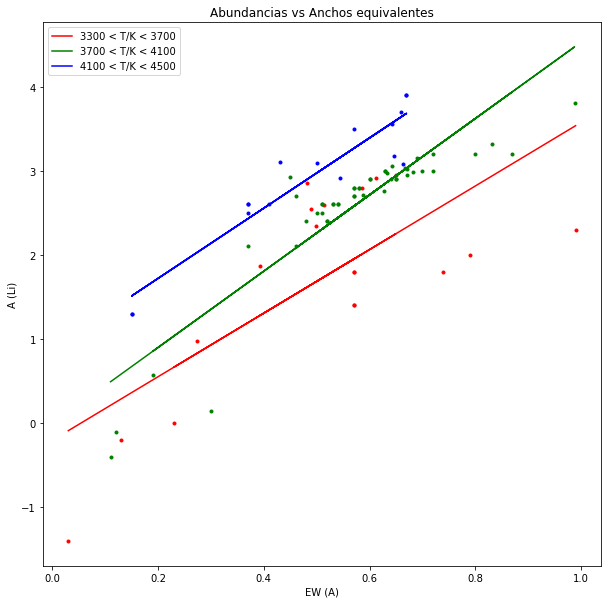

NameError: name 'W_mean_vec' is not defined

In [4]:
# =============================================================================
# AJUSTE CON ESTRELLAS FRÍAS
# =============================================================================

EW_to_A = pd.read_csv("../data/abundances/final_table.csv")
EW_to_A.dropna(inplace = True)

tmin = 3298
tmax = 4673

subset1 = EW_to_A[(EW_to_A.Teff > 3300) & (EW_to_A.Teff < 3700) & (EW_to_A['log_n(Li)'] < 3)]
subset2 = EW_to_A[(EW_to_A.Teff > 3700) & (EW_to_A.Teff < 4100)]
subset3 = EW_to_A[(EW_to_A.Teff > 4100) & (EW_to_A.Teff < 4500)]

w_model1 = subset1['EW']
a_model1 = subset1['log_n(Li)']

w_model2 = subset2['EW']
a_model2 = subset2['log_n(Li)']

w_model3 = subset3['EW']
a_model3 = subset3['log_n(Li)']

#Interpolamos los datos
interp1 = interp1d(w_model1, a_model1, fill_value="extrapolate")
poly1 = np.poly1d(np.polyfit(w_model1, a_model1, 1))

interp2 = interp1d(w_model2, a_model2, fill_value="extrapolate")
poly2 = np.poly1d(np.polyfit(w_model2, a_model2, 1))

interp3 = interp1d(w_model3, a_model3, fill_value="extrapolate")
poly3 = np.poly1d(np.polyfit(w_model3, a_model3, 1))

plt.figure(figsize=(10,10))
plt.plot(w_model1, a_model1, '.r',
        w_model2, a_model2, '.g',
        w_model3, a_model3, '.b')         
plt.plot(w_model1, poly1(w_model1), '-r', label="3300 < T/K < 3700")
plt.plot(w_model2, poly2(w_model2), '-g', label="3700 < T/K < 4100")
plt.plot(w_model3, poly3(w_model3), '-b', label="4100 < T/K < 4500")
plt.xlabel("EW (A)")
plt.ylabel("A (Li)")
plt.title("Abundancias vs Anchos equivalentes")
plt.legend(loc='best')
plt.savefig("./graphics/A_vs_EW_interpolations.jpg")
plt.show()

#Graficamos el ancho equivalente en función de la abundancia
"""
plt.figure(figsize=(6,6))
plt.plot(W_mean_vec, poly2(W_mean_vec), '-')
plt.xlabel("EW (A)")
plt.ylabel("log N(Li)")
plt.title("Abundancia vs Ancho Equivalente")
plt.show()
"""

print(W_mean_vec)
print("Abundancia de Li - 1er Ajuste", poly1(W_mean_vec))
print("Abundancia de Li - 2do Ajuste", poly2(W_mean_vec))
print("Abundancia de Li - 3er Ajuste", poly3(W_mean_vec))